<a href="https://colab.research.google.com/github/chunjie-sam-liu/TEP-prognosis/blob/main/test/pytorchstepbystep03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter3()
# This is needed to render the plots in this chapter
from plots.chapter3 import *

Finished!


In [3]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [4]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

In [5]:
from stepbystep.v0 import StepByStep

# A simple Calssification Problem

In [6]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

In [7]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

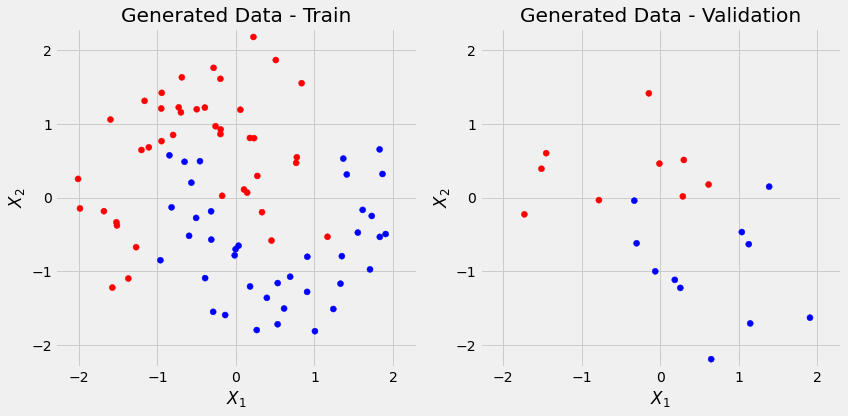

In [8]:
fig = figure1(X_train, y_train, X_val, y_val)

# Data Preparation

In [9]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [10]:
def odds_ratio(prob):
    return prob / (1 - prob)

In [11]:
p = .75
q = 1 - p
odds_ratio(p), odds_ratio(q)

(3.0, 0.3333333333333333)

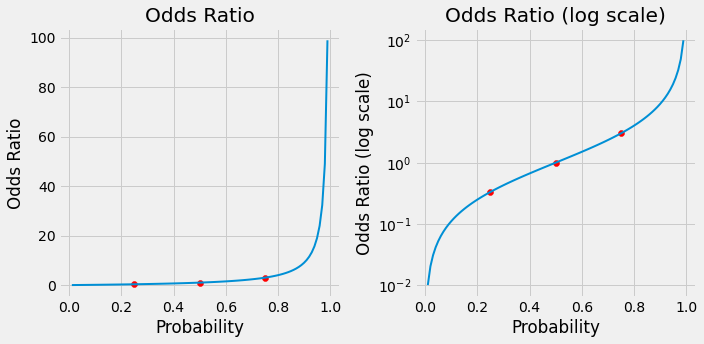

In [12]:
fig = figure2(p)

In [13]:
def log_odds_ratio(prob):
    return np.log(odds_ratio(prob))

p = .75
q = 1 - p
log_odds_ratio(p), log_odds_ratio(q)

(1.0986122886681098, -1.0986122886681098)

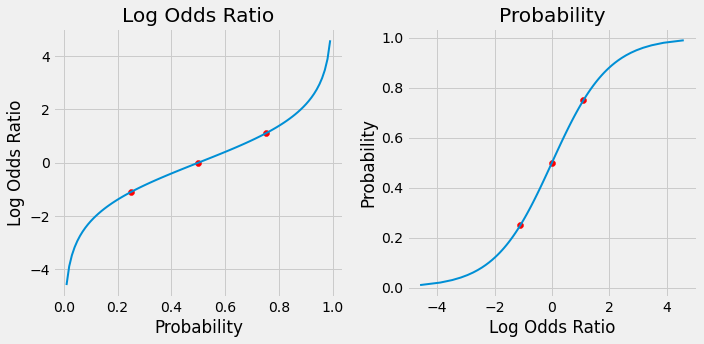

In [14]:
fig = figure3(p)

In [15]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

p = .75
q = 1 - p
sigmoid(log_odds_ratio(p)), sigmoid(log_odds_ratio(q))

(0.75, 0.25)

In [16]:
torch.sigmoid(torch.tensor(1.0986)), torch.sigmoid(torch.tensor(-1.0986))

(tensor(0.7500), tensor(0.2500))

In [17]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear', nn.Linear(2, 1))
model1.add_module('sigmoid', nn.Sigmoid())
print(model1.state_dict())

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])), ('linear.bias', tensor([-0.1657]))])


In [18]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# Positive class (labels == 1)
positive_pred = dummy_predictions[dummy_labels == 1]
first_summation = torch.log(positive_pred).sum()
# Negative class (labels == 0)
negative_pred = dummy_predictions[dummy_labels == 0]
second_summation = torch.log(1 - negative_pred).sum()
# n_total = n_pos + n_neg
n_total = dummy_labels.size(0)

loss = -(first_summation + second_summation) / n_total
loss

tensor(0.1643)

In [19]:
summation = torch.sum(
    dummy_labels * torch.log(dummy_predictions) +
    (1 - dummy_labels) * torch.log(1 - dummy_predictions)
)
loss = -summation / n_total
loss

tensor(0.1643)

In [26]:
import numpy as np
import datetime
import torch
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

plt.style.use('fivethirtyeight')

class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step = self._make_train_step()
        # Creates the val_step function for our model and loss
        self.val_step = self._make_val_step()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        self.device = device
        self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to define a SummaryWriter to interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter('{}/{}_{}'.format(folder, name, suffix))

    def _make_train_step(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer
        
        # Builds function that performs a step in the train loop
        def perform_train_step(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step
    
    def _make_val_step(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step
            
    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and 
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step = self.val_step
        else:
            data_loader = self.train_loader
            step = self.train_step

        if data_loader is None:
            return None
            
        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training   

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))


In [27]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

In [28]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

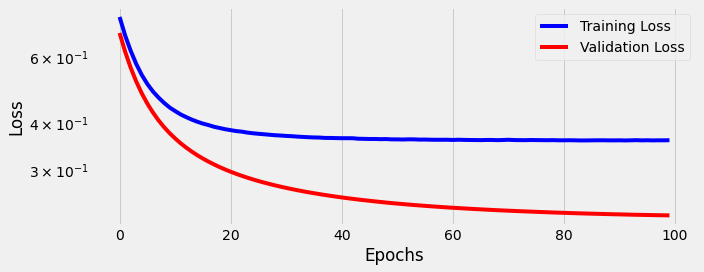

In [29]:
fig = sbs.plot_losses()

In [30]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1815, -1.8690]])), ('linear.bias', tensor([-0.0581]))])


In [31]:
predictions = sbs.predict(x_train_tensor[:4])
predictions

array([[ 0.20382239],
       [ 2.9454765 ],
       [ 3.6952524 ],
       [-1.2338293 ]], dtype=float32)

In [32]:
probabilities = sigmoid(predictions)
probabilities

array([[0.5507799 ],
       [0.9500492 ],
       [0.97576094],
       [0.22551191]], dtype=float32)

In [34]:
classes = (predictions >= 0).astype(np.int)
classes

array([[1],
       [1],
       [1],
       [0]])

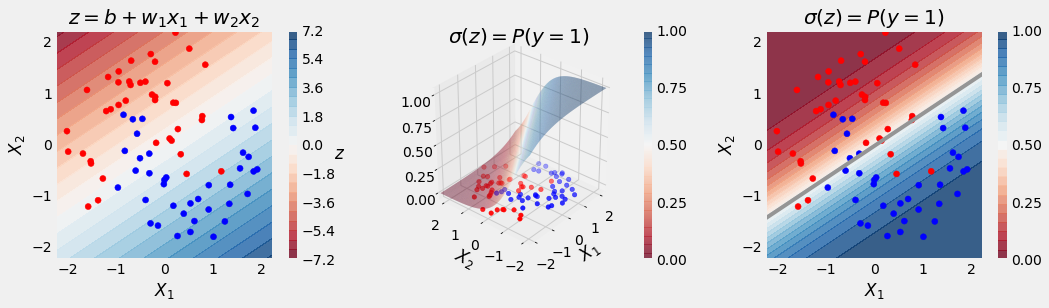

In [35]:
# Training set
fig = figure7(X_train, y_train, sbs.model, sbs.device)

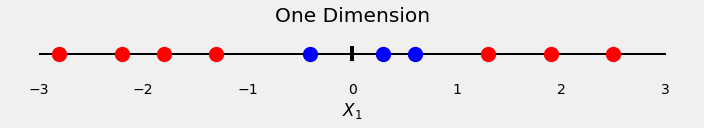

In [36]:
x = np.array([-2.8, -2.2, -1.8, -1.3, -.4, 0.3, 0.6, 1.3, 1.9, 2.5])
y = np.array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0.])

fig = one_dimension(x, y)

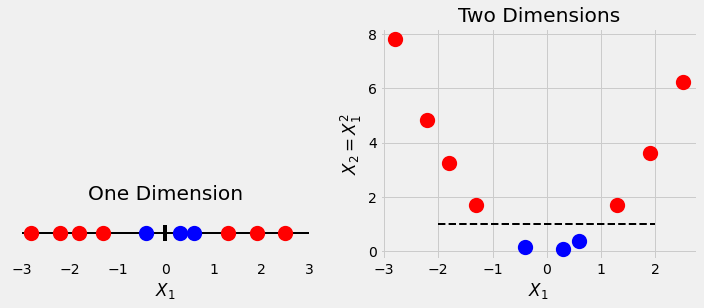

In [37]:
fig = two_dimensions(x, y)

In [38]:
model = nn.Sequential()
model.add_module('hidden', nn.Linear(2, 10))
model.add_module('activation', nn.ReLU())
model.add_module('output', nn.Linear(10, 1))
model.add_module('sigmoid', nn.Sigmoid())

loss_fn = nn.BCELoss()

In [39]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
threshold = 0.5

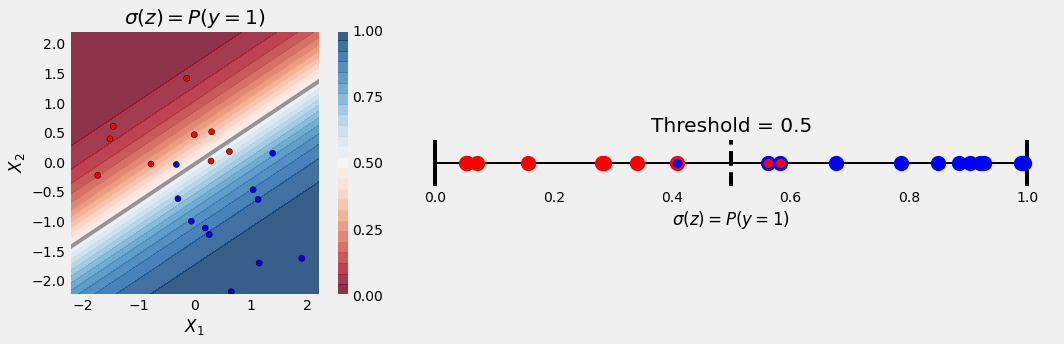

In [40]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold)

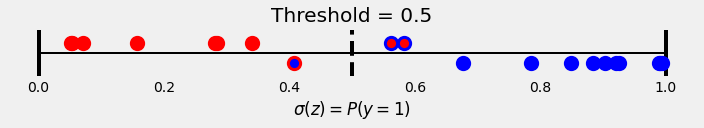

In [41]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, False)

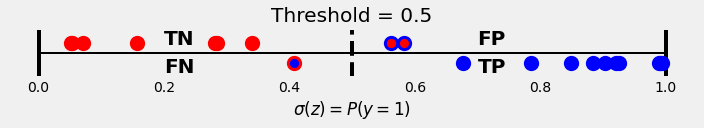

In [42]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, True)

In [43]:
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= .5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])

In [44]:
def split_cm(cm):
    # Actual negatives go in the top row, 
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row, 
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]
    
    return tn, fp, fn, tp

In [45]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    return tpr, fpr

In [46]:
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    return precision, recall

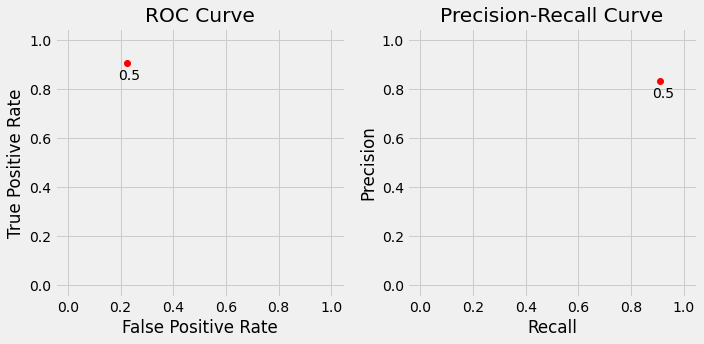

In [47]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.5], annot=True)


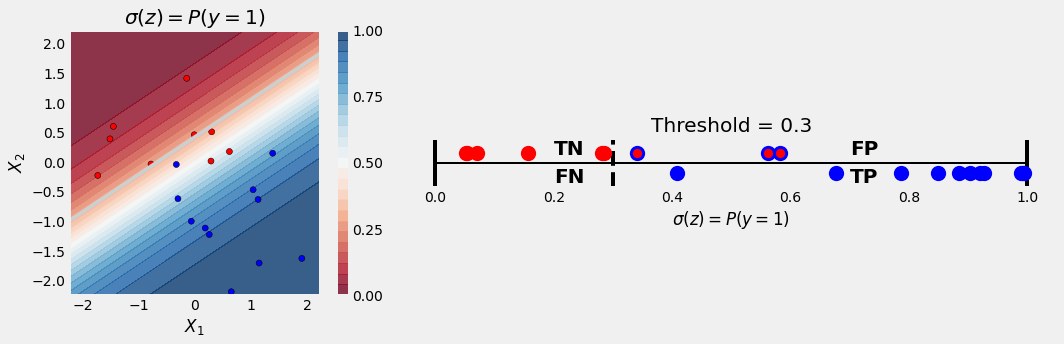

In [48]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.3, shift=0.04, annot=True)

In [49]:
confusion_matrix(y_val, (probabilities_val >= 0.3))

array([[ 6,  3],
       [ 0, 11]])

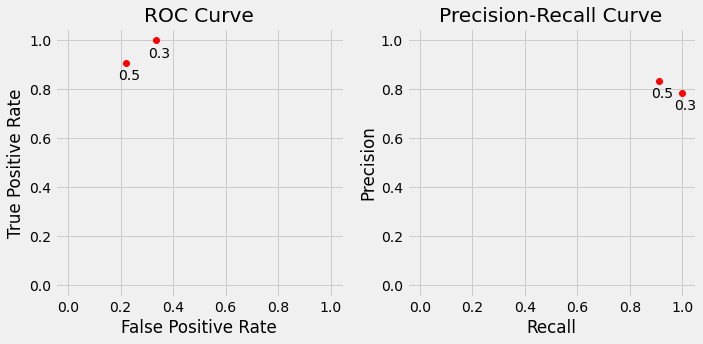

In [50]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5], annot=True)

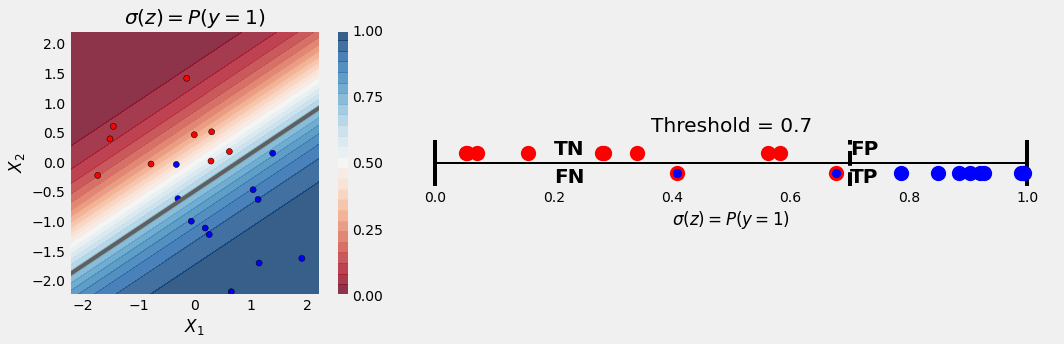

In [51]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.7, shift=0.04, annot=True)

In [52]:
confusion_matrix(y_val, (probabilities_val >= 0.7))

array([[9, 0],
       [2, 9]])

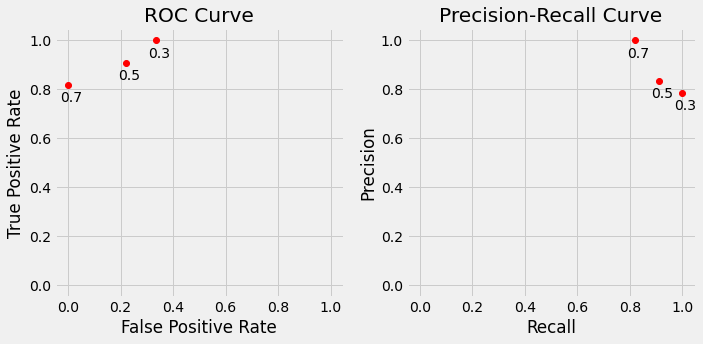

In [53]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5, .7], annot=True)


In [54]:
threshs = np.linspace(0.,1,11)

/content/plots/chapter3.py:49: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


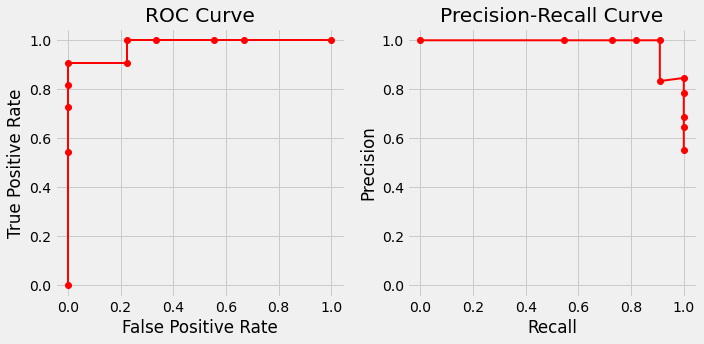

In [55]:
fig = figure17(y_val, probabilities_val, threshs)

In [56]:
fpr, tpr, thresholds1 = roc_curve(y_val, probabilities_val)
prec, rec, thresholds2 = precision_recall_curve(y_val, probabilities_val)

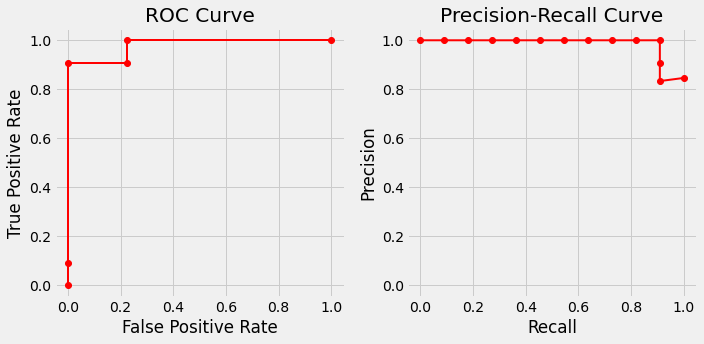

In [57]:
fig = eval_curves(fpr, tpr, rec, prec, thresholds1, thresholds2, line=True)

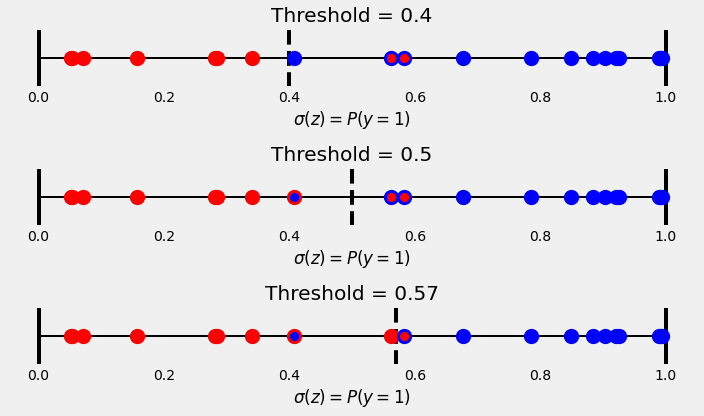

In [58]:
fig = figure19(y_val, probabilities_val)

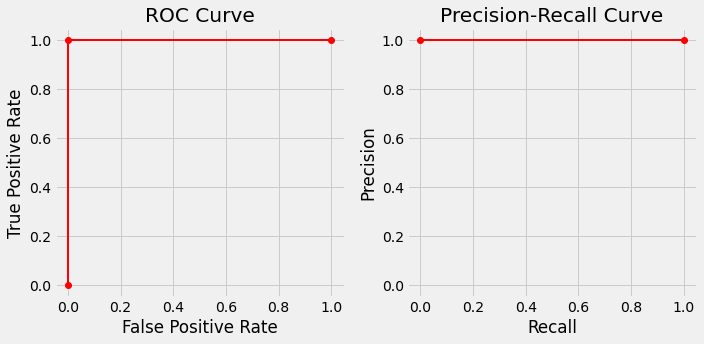

In [59]:
# Best
fig = figure20(y_val)

In [60]:
np.random.seed(39)
random_probs = np.random.uniform(size=y_val.shape)

In [61]:
fpr_random, tpr_random, thresholds1_random = roc_curve(y_val, random_probs)
prec_random, rec_random, thresholds2_random = precision_recall_curve(y_val, random_probs)

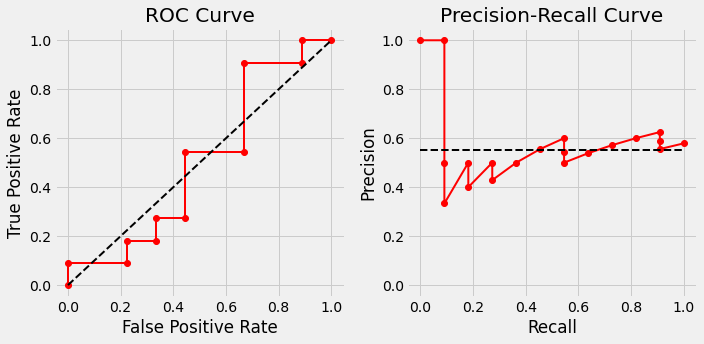

In [62]:
# Worst
fig = figure21(y_val, random_probs)

In [63]:
# Area under the curves of our model
auroc = auc(fpr, tpr)
aupr = auc(rec, prec)
print(auroc, aupr)

0.9797979797979798 0.9854312354312356


In [64]:
# Area under the curves of the random model
auroc_random = auc(fpr_random, tpr_random)
aupr_random = auc(rec_random, prec_random)
print(auroc_random, aupr_random)

0.505050505050505 0.570559046216941


In [65]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=16, 
    shuffle=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [66]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

In [67]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

In [68]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])